In [21]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

C:\Users\patri\AppData\Local\Temp\ipykernel_17432\387698996.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\patri\AppData\Local\Temp\ipykernel_17432\387698996.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\patri\AppData\Local\Temp\ipykernel_17432\387698996.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\patri\AppData\Local\Temp\ipykernel_17432\387698996.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecat

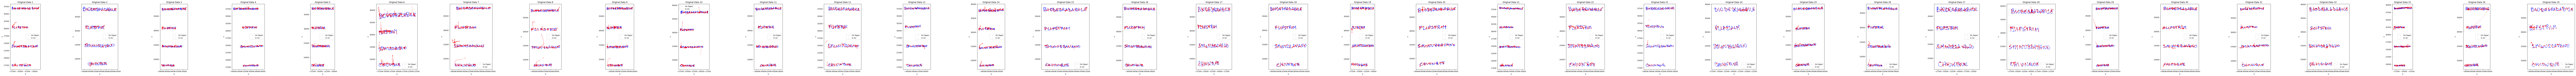

Number of processed files: 35
Average number of data points: 3942


In [38]:
# Cell 2
# Updated function
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []  # Processed data after scaling
    original_data_frames = []  # Save the original unscaled data
    scalers = []
    input_filenames = []  # List to store input filenames

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    # Create the folder if it doesn't exist
    output_folder = 'original_absolute'
    os.makedirs(output_folder, exist_ok=True)

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        input_filenames.append(filename)  # Store the filename
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        # Save the modified data to the 'original_absolute' folder
        save_path = os.path.join(output_folder, filename)
        df.to_csv(save_path, sep=' ', index=False, header=False)
        
        # Keep a copy of the original data before scaling
        original_data_frames.append(df.copy())  # Save the original unmodified data
        
        # Process the data for use in the model
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames  # Return original data

directory = 'Task3'  # Directory where the .svc files are stored
num_files_to_use = 35
data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)

# Store the name of the first file for use in Cell 4
input_filename = input_filenames[0] if input_filenames else 'processed_data'
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")


In [39]:
# Cell 3
# Process each DataFrame instead of just the first one
for df_idx in range(len(data_frames)):
    df = data_frames[df_idx]  # Using each DataFrame in the list

    # Convert the 'timestamp' column to numeric for calculations (if not already done)
    df['timestamp'] = pd.to_numeric(df['timestamp'])

    # Sort the DataFrame by timestamp (should already be sorted in the function)
    df.sort_values('timestamp', inplace=True)

    # Calculate the differences between consecutive timestamps (optional for gap finding)
    df['time_diff'] = df['timestamp'].diff()

    # Identify the indices where the time difference is greater than 30,000 milliseconds
    gap_indices = df.index[df['time_diff'] > 8].tolist()

    # Create an empty list to hold the new rows
    new_rows = []

    # Fill in the gaps with 70 milliseconds intervals
    for idx in gap_indices:
        # Check if the next index is valid
        if idx + 1 < len(df):
            # Get the current and next timestamps
            current_timestamp = df.at[idx, 'timestamp']
            next_timestamp = df.at[idx + 1, 'timestamp']

            # Calculate how many entries we need to fill in
            num_fill_entries = (next_timestamp - current_timestamp) // 7

            # Generate the timestamps to fill the gap
            for i in range(1, num_fill_entries + 1):
                new_timestamp = current_timestamp + i * 7

                # Create a new row to fill in with NaN for x and y
                new_row = {
                    'x': np.nan,  # Set x to NaN
                    'y': np.nan,  # Set y to NaN
                    'timestamp': new_timestamp,
                    'pen_status': 0,        # You can set this to your desired value
                    'azimuth': df.at[idx, 'azimuth'],   # Use the current azimuth value
                    'altitude': df.at[idx, 'altitude'], # Use the current altitude value
                    'pressure': df.at[idx, 'pressure']  # Use the current pressure value
                }

                # Append the new row to the list of new rows
                new_rows.append(new_row)

    # Create a DataFrame from the new rows
    new_rows_df = pd.DataFrame(new_rows)

    # Concatenate the original DataFrame with the new rows DataFrame
    df = pd.concat([df, new_rows_df], ignore_index=True)

    # Sort the DataFrame by timestamp to maintain order
    df.sort_values('timestamp', inplace=True)

    # Reset index after sorting
    df.reset_index(drop=True, inplace=True)


    # Check for NaN entries before interpolation
    if df[['x', 'y']].isnull().any().any():
        df[['x', 'y']] = df[['x', 'y']].interpolate(method='linear')

    # Drop the 'time_diff' column after processing
    df.drop(columns=['time_diff'], inplace=True)

    # Update the processed data
    data_frames[df_idx] = df

# Update processed data for all DataFrames
processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                  for df, scaler in zip(data_frames, scalers)]
avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

In [44]:

# Cell 4
processed_dataframes = []

for input_filename, df in zip(input_filenames, data_frames):
    # Convert all numeric columns to integers
    df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']] = df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']].astype(int)
    
    # Append the processed DataFrame to the list
    processed_dataframes.append(df)

    # print(f"Processed DataFrame for: {input_filename}")



In [25]:
# Cell 5 (modified)
def process_dataframes(dataframes, num_files_to_use=None):
    if num_files_to_use:
        dataframes = dataframes[:num_files_to_use]

    data_frames = []
    scalers = []

    for i, df in enumerate(dataframes):
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        data_frames.append(df)
        scaler = MinMaxScaler()
        scaler.fit(df[['x', 'y', 'timestamp']])  # Fit the scaler
        scalers.append(scaler)

        # Print the first few rows of the timestamp column
        # print(f"Modified timestamps for DataFrame {i + 1}:")
        # print(df['timestamp'].head())
        # print("\n")

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, [f"DataFrame_{i+1}" for i in range(len(dataframes))]

# Use the processed_dataframes directly 
data_frames, processed_data, scalers, avg_data_points, original_filenames = process_dataframes(processed_dataframes, num_files_to_use)
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")

Number of processed files: 35
Average number of data points: 3854


In [31]:
# Cell 6 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0, lambda_shift=0.01, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.beta = beta
        self.lambda_shift = lambda_shift
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        # Apply shift correction
        return eps * tf.exp(logvar * .5) + (mean + self.lambda_shift * tf.exp(logvar * .5))

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    @classmethod
    def from_config(cls, config):
        config.pop('trainable', None)
        config.pop('dtype', None)
        return cls(**config)

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'latent_dim': self.latent_dim,
            'beta': self.beta,
            'lambda_shift': self.lambda_shift
        })
        return config


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)


# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


# Parameters for VAE
latent_dim = 1024
beta = 0.000001
learning_rate = 0.001
lambda_shift = 0.5

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [32]:
# Cell 7 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, base_latent_variability=1.0, latent_variability_range=(0.5, 2.0)):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        selected_data = processed_data[i % num_input_files]
        original_data = data_frames[i % num_input_files]
        pressure_azimuth_altitude = original_data[['pressure', 'azimuth', 'altitude']].values
        
        latent_variability = base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1])
        
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()

        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        augmented_data = np.column_stack((augmented_data, pressure_azimuth_altitude[:augmented_data.shape[0]]))
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/200: 100%|██████████| 279/279 [00:37<00:00,  7.48batch/s, Generator Loss=0.0509, Reconstruction Loss=0.0509, KL Loss=0.0678]


Epoch 1: Generator Loss = 0.144634, Reconstruction Loss = 0.144634, KL Divergence Loss = 0.036781


Epoch 2/200: 100%|██████████| 279/279 [00:07<00:00, 35.26batch/s, Generator Loss=0.00956, Reconstruction Loss=0.00956, KL Loss=0.522]


Epoch 2: Generator Loss = 0.040598, Reconstruction Loss = 0.040598, KL Divergence Loss = 0.203073


Epoch 3/200: 100%|██████████| 279/279 [00:07<00:00, 38.74batch/s, Generator Loss=0.00286, Reconstruction Loss=0.00286, KL Loss=1.05] 


Epoch 3: Generator Loss = 0.009531, Reconstruction Loss = 0.009531, KL Divergence Loss = 0.730873


Epoch 4/200: 100%|██████████| 279/279 [00:06<00:00, 41.15batch/s, Generator Loss=0.00111, Reconstruction Loss=0.00111, KL Loss=1.64]  


Epoch 4: Generator Loss = 0.002571, Reconstruction Loss = 0.002571, KL Divergence Loss = 1.291708


Epoch 5/200: 100%|██████████| 279/279 [00:06<00:00, 43.21batch/s, Generator Loss=0.000535, Reconstruction Loss=0.000535, KL Loss=2.04]


Epoch 5: Generator Loss = 0.001230, Reconstruction Loss = 0.001230, KL Divergence Loss = 1.854392


Epoch 6/200: 100%|██████████| 279/279 [00:06<00:00, 43.23batch/s, Generator Loss=0.000393, Reconstruction Loss=0.000393, KL Loss=2.22]


Epoch 6: Generator Loss = 0.001025, Reconstruction Loss = 0.001025, KL Divergence Loss = 2.132571


Epoch 7/200: 100%|██████████| 279/279 [00:06<00:00, 43.29batch/s, Generator Loss=0.000379, Reconstruction Loss=0.000379, KL Loss=2.48]


Epoch 7: Generator Loss = 0.000826, Reconstruction Loss = 0.000826, KL Divergence Loss = 2.338493


Epoch 8/200: 100%|██████████| 279/279 [00:06<00:00, 43.04batch/s, Generator Loss=0.000256, Reconstruction Loss=0.000256, KL Loss=2.58]


Epoch 8: Generator Loss = 0.000635, Reconstruction Loss = 0.000635, KL Divergence Loss = 2.524563


Epoch 9/200: 100%|██████████| 279/279 [00:06<00:00, 42.48batch/s, Generator Loss=0.000351, Reconstruction Loss=0.000351, KL Loss=2.81]


Epoch 9: Generator Loss = 0.000507, Reconstruction Loss = 0.000507, KL Divergence Loss = 2.682063


Epoch 10/200: 100%|██████████| 279/279 [00:06<00:00, 43.21batch/s, Generator Loss=0.000289, Reconstruction Loss=0.000289, KL Loss=2.91]


Epoch 10: Generator Loss = 0.000505, Reconstruction Loss = 0.000505, KL Divergence Loss = 2.799559


Epoch 11/200: 100%|██████████| 279/279 [00:06<00:00, 43.13batch/s, Generator Loss=0.000272, Reconstruction Loss=0.000272, KL Loss=2.96]


Epoch 11: Generator Loss = 0.000470, Reconstruction Loss = 0.000470, KL Divergence Loss = 2.901151


Epoch 12/200: 100%|██████████| 279/279 [00:06<00:00, 43.39batch/s, Generator Loss=0.000285, Reconstruction Loss=0.000285, KL Loss=3.02]


Epoch 12: Generator Loss = 0.000424, Reconstruction Loss = 0.000424, KL Divergence Loss = 2.978691


Epoch 13/200: 100%|██████████| 279/279 [00:06<00:00, 39.98batch/s, Generator Loss=0.000245, Reconstruction Loss=0.000245, KL Loss=3.1] 


Epoch 13: Generator Loss = 0.000398, Reconstruction Loss = 0.000398, KL Divergence Loss = 3.045570


Epoch 14/200: 100%|██████████| 279/279 [00:06<00:00, 42.44batch/s, Generator Loss=0.000148, Reconstruction Loss=0.000148, KL Loss=3.1] 


Epoch 14: Generator Loss = 0.000345, Reconstruction Loss = 0.000345, KL Divergence Loss = 3.138488


Epoch 15/200: 100%|██████████| 279/279 [00:07<00:00, 39.16batch/s, Generator Loss=0.000127, Reconstruction Loss=0.000127, KL Loss=3.23]


Epoch 15: Generator Loss = 0.000280, Reconstruction Loss = 0.000280, KL Divergence Loss = 3.220292


Epoch 16/200: 100%|██████████| 279/279 [00:06<00:00, 43.01batch/s, Generator Loss=8.61e-5, Reconstruction Loss=8.61e-5, KL Loss=3.28]  


Epoch 16: Generator Loss = 0.000288, Reconstruction Loss = 0.000288, KL Divergence Loss = 3.274413


Epoch 17/200: 100%|██████████| 279/279 [00:06<00:00, 40.22batch/s, Generator Loss=0.000145, Reconstruction Loss=0.000145, KL Loss=3.37]


Epoch 17: Generator Loss = 0.000238, Reconstruction Loss = 0.000238, KL Divergence Loss = 3.343589


Epoch 18/200: 100%|██████████| 279/279 [00:07<00:00, 39.83batch/s, Generator Loss=0.000117, Reconstruction Loss=0.000117, KL Loss=3.41]


Epoch 18: Generator Loss = 0.000308, Reconstruction Loss = 0.000308, KL Divergence Loss = 3.359881


Epoch 19/200: 100%|██████████| 279/279 [00:06<00:00, 43.04batch/s, Generator Loss=8.97e-5, Reconstruction Loss=8.97e-5, KL Loss=3.47]  


Epoch 19: Generator Loss = 0.000178, Reconstruction Loss = 0.000178, KL Divergence Loss = 3.464642


Epoch 20/200: 100%|██████████| 279/279 [00:06<00:00, 43.45batch/s, Generator Loss=7.94e-5, Reconstruction Loss=7.94e-5, KL Loss=3.4]   


Epoch 20: Generator Loss = 0.000335, Reconstruction Loss = 0.000335, KL Divergence Loss = 3.436333


Epoch 21/200: 100%|██████████| 279/279 [00:06<00:00, 43.55batch/s, Generator Loss=6.69e-5, Reconstruction Loss=6.69e-5, KL Loss=3.44]  


Epoch 21: Generator Loss = 0.000315, Reconstruction Loss = 0.000315, KL Divergence Loss = 3.439066


Epoch 22/200: 100%|██████████| 279/279 [00:06<00:00, 44.10batch/s, Generator Loss=7.11e-5, Reconstruction Loss=7.11e-5, KL Loss=3.52]  


Epoch 22: Generator Loss = 0.000156, Reconstruction Loss = 0.000156, KL Divergence Loss = 3.533778


Epoch 23/200: 100%|██████████| 279/279 [00:06<00:00, 43.21batch/s, Generator Loss=7.42e-5, Reconstruction Loss=7.42e-5, KL Loss=3.43]  


Epoch 23: Generator Loss = 0.000380, Reconstruction Loss = 0.000380, KL Divergence Loss = 3.469607


Epoch 24/200: 100%|██████████| 279/279 [00:06<00:00, 43.53batch/s, Generator Loss=3.88e-5, Reconstruction Loss=3.88e-5, KL Loss=3.55]  


Epoch 24: Generator Loss = 0.000142, Reconstruction Loss = 0.000142, KL Divergence Loss = 3.540732


Epoch 25/200: 100%|██████████| 279/279 [00:06<00:00, 42.64batch/s, Generator Loss=7.6e-5, Reconstruction Loss=7.6e-5, KL Loss=3.67]    


Epoch 25: Generator Loss = 0.000118, Reconstruction Loss = 0.000118, KL Divergence Loss = 3.667501


Epoch 26/200: 100%|██████████| 279/279 [00:06<00:00, 43.27batch/s, Generator Loss=4.62e-5, Reconstruction Loss=4.62e-5, KL Loss=3.71]  


Epoch 26: Generator Loss = 0.000143, Reconstruction Loss = 0.000143, KL Divergence Loss = 3.730955


Epoch 27/200: 100%|██████████| 279/279 [00:06<00:00, 45.06batch/s, Generator Loss=2.71e-5, Reconstruction Loss=2.71e-5, KL Loss=3.81]  


Epoch 27: Generator Loss = 0.000118, Reconstruction Loss = 0.000118, KL Divergence Loss = 3.797720


Epoch 28/200: 100%|██████████| 279/279 [00:06<00:00, 45.86batch/s, Generator Loss=6.56e-5, Reconstruction Loss=6.56e-5, KL Loss=3.7]   


Epoch 28: Generator Loss = 0.000191, Reconstruction Loss = 0.000191, KL Divergence Loss = 3.795985


Epoch 29/200: 100%|██████████| 279/279 [00:06<00:00, 45.46batch/s, Generator Loss=4.2e-5, Reconstruction Loss=4.2e-5, KL Loss=3.83]    


Epoch 29: Generator Loss = 0.000129, Reconstruction Loss = 0.000129, KL Divergence Loss = 3.819618


Epoch 30/200: 100%|██████████| 279/279 [00:06<00:00, 43.86batch/s, Generator Loss=4.28e-5, Reconstruction Loss=4.28e-5, KL Loss=3.83]  


Epoch 30: Generator Loss = 0.000148, Reconstruction Loss = 0.000148, KL Divergence Loss = 3.850103


Epoch 31/200: 100%|██████████| 279/279 [00:06<00:00, 45.71batch/s, Generator Loss=4.43e-5, Reconstruction Loss=4.43e-5, KL Loss=3.88]  


Epoch 31: Generator Loss = 0.000107, Reconstruction Loss = 0.000107, KL Divergence Loss = 3.909107


Epoch 32/200: 100%|██████████| 279/279 [00:06<00:00, 44.95batch/s, Generator Loss=0.00019, Reconstruction Loss=0.00019, KL Loss=3.89]  


Epoch 32: Generator Loss = 0.000132, Reconstruction Loss = 0.000132, KL Divergence Loss = 3.957165


Epoch 33/200: 100%|██████████| 279/279 [00:06<00:00, 45.46batch/s, Generator Loss=3.21e-5, Reconstruction Loss=3.21e-5, KL Loss=3.84]  


Epoch 33: Generator Loss = 0.000183, Reconstruction Loss = 0.000183, KL Divergence Loss = 3.888225


Epoch 34/200: 100%|██████████| 279/279 [00:06<00:00, 45.33batch/s, Generator Loss=2.91e-5, Reconstruction Loss=2.91e-5, KL Loss=3.8]   


Epoch 34: Generator Loss = 0.000188, Reconstruction Loss = 0.000188, KL Divergence Loss = 3.845273


Epoch 35/200: 100%|██████████| 279/279 [00:06<00:00, 45.56batch/s, Generator Loss=4.32e-5, Reconstruction Loss=4.32e-5, KL Loss=3.89]  


Epoch 35: Generator Loss = 0.000090, Reconstruction Loss = 0.000090, KL Divergence Loss = 3.925507


Epoch 36/200: 100%|██████████| 279/279 [00:06<00:00, 45.65batch/s, Generator Loss=4.85e-5, Reconstruction Loss=4.85e-5, KL Loss=3.94]  


Epoch 36: Generator Loss = 0.000117, Reconstruction Loss = 0.000117, KL Divergence Loss = 3.968081


Epoch 37/200: 100%|██████████| 279/279 [00:06<00:00, 45.17batch/s, Generator Loss=2.93e-5, Reconstruction Loss=2.93e-5, KL Loss=4.01]  


Epoch 37: Generator Loss = 0.000075, Reconstruction Loss = 0.000075, KL Divergence Loss = 4.037855


Epoch 38/200: 100%|██████████| 279/279 [00:06<00:00, 45.09batch/s, Generator Loss=4.31e-5, Reconstruction Loss=4.31e-5, KL Loss=4.06]  


Epoch 38: Generator Loss = 0.000104, Reconstruction Loss = 0.000104, KL Divergence Loss = 4.087486


Epoch 39/200: 100%|██████████| 279/279 [00:06<00:00, 44.81batch/s, Generator Loss=4.24e-5, Reconstruction Loss=4.24e-5, KL Loss=3.99]  


Epoch 39: Generator Loss = 0.000147, Reconstruction Loss = 0.000147, KL Divergence Loss = 4.050153


Epoch 40/200: 100%|██████████| 279/279 [00:06<00:00, 45.65batch/s, Generator Loss=3.17e-5, Reconstruction Loss=3.17e-5, KL Loss=3.93]  


Epoch 40: Generator Loss = 0.000154, Reconstruction Loss = 0.000154, KL Divergence Loss = 4.000710


Epoch 41/200: 100%|██████████| 279/279 [00:06<00:00, 45.50batch/s, Generator Loss=2.97e-5, Reconstruction Loss=2.97e-5, KL Loss=4.03]  


Epoch 41: Generator Loss = 0.000113, Reconstruction Loss = 0.000113, KL Divergence Loss = 4.012516


Epoch 42/200: 100%|██████████| 279/279 [00:06<00:00, 44.01batch/s, Generator Loss=2.7e-5, Reconstruction Loss=2.7e-5, KL Loss=4.04]    


Epoch 42: Generator Loss = 0.000086, Reconstruction Loss = 0.000086, KL Divergence Loss = 4.085583


Epoch 43/200: 100%|██████████| 279/279 [00:06<00:00, 41.24batch/s, Generator Loss=3.46e-5, Reconstruction Loss=3.46e-5, KL Loss=4.06]  


Epoch 43: Generator Loss = 0.000106, Reconstruction Loss = 0.000106, KL Divergence Loss = 4.089959


Epoch 44/200: 100%|██████████| 279/279 [00:06<00:00, 42.83batch/s, Generator Loss=4.39e-5, Reconstruction Loss=4.39e-5, KL Loss=3.89]  


Epoch 44: Generator Loss = 0.000213, Reconstruction Loss = 0.000213, KL Divergence Loss = 3.992553


Epoch 45/200: 100%|██████████| 279/279 [00:06<00:00, 44.61batch/s, Generator Loss=2.69e-5, Reconstruction Loss=2.69e-5, KL Loss=3.92]  


Epoch 45: Generator Loss = 0.000106, Reconstruction Loss = 0.000106, KL Divergence Loss = 3.967793


Epoch 46/200: 100%|██████████| 279/279 [00:06<00:00, 45.40batch/s, Generator Loss=3.53e-5, Reconstruction Loss=3.53e-5, KL Loss=4.06]  


Epoch 46: Generator Loss = 0.000066, Reconstruction Loss = 0.000066, KL Divergence Loss = 4.064170


Epoch 47/200: 100%|██████████| 279/279 [00:06<00:00, 46.12batch/s, Generator Loss=7.11e-5, Reconstruction Loss=7.11e-5, KL Loss=4.08]  


Epoch 47: Generator Loss = 0.000084, Reconstruction Loss = 0.000084, KL Divergence Loss = 4.109128


Epoch 48/200: 100%|██████████| 279/279 [00:06<00:00, 42.88batch/s, Generator Loss=2.5e-5, Reconstruction Loss=2.5e-5, KL Loss=4.08]    


Epoch 48: Generator Loss = 0.000080, Reconstruction Loss = 0.000080, KL Divergence Loss = 4.127444


Epoch 49/200: 100%|██████████| 279/279 [00:06<00:00, 46.04batch/s, Generator Loss=4.58e-5, Reconstruction Loss=4.58e-5, KL Loss=4.08]  


Epoch 49: Generator Loss = 0.000082, Reconstruction Loss = 0.000082, KL Divergence Loss = 4.123191


Epoch 50/200: 100%|██████████| 279/279 [00:06<00:00, 45.28batch/s, Generator Loss=4.51e-5, Reconstruction Loss=4.51e-5, KL Loss=4.1]   


Epoch 50: Generator Loss = 0.000097, Reconstruction Loss = 0.000097, KL Divergence Loss = 4.130113


Epoch 51/200: 100%|██████████| 279/279 [00:06<00:00, 45.67batch/s, Generator Loss=7.73e-5, Reconstruction Loss=7.73e-5, KL Loss=4.12]  


Epoch 51: Generator Loss = 0.000078, Reconstruction Loss = 0.000078, KL Divergence Loss = 4.151763


Epoch 52/200: 100%|██████████| 279/279 [00:06<00:00, 46.20batch/s, Generator Loss=2.58e-5, Reconstruction Loss=2.58e-5, KL Loss=4.04]  


Epoch 52: Generator Loss = 0.000101, Reconstruction Loss = 0.000101, KL Divergence Loss = 4.098267


Epoch 53/200: 100%|██████████| 279/279 [00:06<00:00, 44.95batch/s, Generator Loss=2.54e-5, Reconstruction Loss=2.54e-5, KL Loss=4.06]  


Epoch 53: Generator Loss = 0.000075, Reconstruction Loss = 0.000075, KL Divergence Loss = 4.110904


Epoch 54/200: 100%|██████████| 279/279 [00:06<00:00, 45.94batch/s, Generator Loss=3.39e-5, Reconstruction Loss=3.39e-5, KL Loss=4.1]   


Epoch 54: Generator Loss = 0.000048, Reconstruction Loss = 0.000048, KL Divergence Loss = 4.170413


Epoch 55/200: 100%|██████████| 279/279 [00:06<00:00, 45.32batch/s, Generator Loss=5.88e-5, Reconstruction Loss=5.88e-5, KL Loss=4.12]  


Epoch 55: Generator Loss = 0.000081, Reconstruction Loss = 0.000081, KL Divergence Loss = 4.157101


Epoch 56/200: 100%|██████████| 279/279 [00:06<00:00, 43.99batch/s, Generator Loss=2.95e-5, Reconstruction Loss=2.95e-5, KL Loss=4.12]  


Epoch 56: Generator Loss = 0.000076, Reconstruction Loss = 0.000076, KL Divergence Loss = 4.151950


Epoch 57/200: 100%|██████████| 279/279 [00:06<00:00, 45.21batch/s, Generator Loss=2.41e-5, Reconstruction Loss=2.41e-5, KL Loss=4.15]  


Epoch 57: Generator Loss = 0.000050, Reconstruction Loss = 0.000050, KL Divergence Loss = 4.186548


Epoch 58/200: 100%|██████████| 279/279 [00:06<00:00, 45.27batch/s, Generator Loss=3.31e-5, Reconstruction Loss=3.31e-5, KL Loss=3.93]  


Epoch 58: Generator Loss = 0.000231, Reconstruction Loss = 0.000231, KL Divergence Loss = 4.021003


Epoch 59/200: 100%|██████████| 279/279 [00:06<00:00, 45.89batch/s, Generator Loss=3.08e-5, Reconstruction Loss=3.08e-5, KL Loss=3.82]  


Epoch 59: Generator Loss = 0.000133, Reconstruction Loss = 0.000133, KL Divergence Loss = 3.936891


Epoch 60/200: 100%|██████████| 279/279 [00:06<00:00, 44.09batch/s, Generator Loss=1.6e-5, Reconstruction Loss=1.6e-5, KL Loss=3.96]    


Epoch 60: Generator Loss = 0.000061, Reconstruction Loss = 0.000061, KL Divergence Loss = 3.992069


Epoch 61/200: 100%|██████████| 279/279 [00:09<00:00, 28.88batch/s, Generator Loss=2.16e-5, Reconstruction Loss=2.16e-5, KL Loss=3.9]   


Epoch 61: Generator Loss = 0.000142, Reconstruction Loss = 0.000142, KL Divergence Loss = 3.957152


Epoch 62/200: 100%|██████████| 279/279 [00:07<00:00, 36.76batch/s, Generator Loss=2.62e-5, Reconstruction Loss=2.62e-5, KL Loss=3.92]  


Epoch 62: Generator Loss = 0.000073, Reconstruction Loss = 0.000073, KL Divergence Loss = 3.959908


Epoch 63/200: 100%|██████████| 279/279 [00:06<00:00, 40.40batch/s, Generator Loss=1.48e-5, Reconstruction Loss=1.48e-5, KL Loss=4.01]  


Epoch 63: Generator Loss = 0.000056, Reconstruction Loss = 0.000056, KL Divergence Loss = 4.010788


Epoch 64/200: 100%|██████████| 279/279 [00:06<00:00, 40.33batch/s, Generator Loss=2.05e-5, Reconstruction Loss=2.05e-5, KL Loss=4]     


Epoch 64: Generator Loss = 0.000047, Reconstruction Loss = 0.000047, KL Divergence Loss = 4.061157


Epoch 65/200: 100%|██████████| 279/279 [00:06<00:00, 43.05batch/s, Generator Loss=1.96e-5, Reconstruction Loss=1.96e-5, KL Loss=3.98]  


Epoch 65: Generator Loss = 0.000079, Reconstruction Loss = 0.000079, KL Divergence Loss = 4.070258


Epoch 66/200: 100%|██████████| 279/279 [00:06<00:00, 41.84batch/s, Generator Loss=1.85e-5, Reconstruction Loss=1.85e-5, KL Loss=4.03]  


Epoch 66: Generator Loss = 0.000044, Reconstruction Loss = 0.000044, KL Divergence Loss = 4.073892


Epoch 67/200: 100%|██████████| 279/279 [00:06<00:00, 43.11batch/s, Generator Loss=3.39e-5, Reconstruction Loss=3.39e-5, KL Loss=3.99]  


Epoch 67: Generator Loss = 0.000078, Reconstruction Loss = 0.000078, KL Divergence Loss = 4.075655


Epoch 68/200: 100%|██████████| 279/279 [00:06<00:00, 41.87batch/s, Generator Loss=1.28e-5, Reconstruction Loss=1.28e-5, KL Loss=4.1]   


Epoch 68: Generator Loss = 0.000030, Reconstruction Loss = 0.000030, KL Divergence Loss = 4.118475


Epoch 69/200: 100%|██████████| 279/279 [00:06<00:00, 41.08batch/s, Generator Loss=4.94e-5, Reconstruction Loss=4.94e-5, KL Loss=4.04]  


Epoch 69: Generator Loss = 0.000059, Reconstruction Loss = 0.000059, KL Divergence Loss = 4.119213


Epoch 70/200: 100%|██████████| 279/279 [00:07<00:00, 37.44batch/s, Generator Loss=0.00115, Reconstruction Loss=0.00115, KL Loss=2.21]  


Epoch 70: Generator Loss = 0.034708, Reconstruction Loss = 0.034708, KL Divergence Loss = 2.774656


Epoch 71/200: 100%|██████████| 279/279 [00:07<00:00, 38.31batch/s, Generator Loss=0.000615, Reconstruction Loss=0.000615, KL Loss=2.61]


Epoch 71: Generator Loss = 0.000675, Reconstruction Loss = 0.000675, KL Divergence Loss = 2.375499


Epoch 72/200: 100%|██████████| 279/279 [00:07<00:00, 37.44batch/s, Generator Loss=0.000348, Reconstruction Loss=0.000348, KL Loss=2.71]


Epoch 72: Generator Loss = 0.000421, Reconstruction Loss = 0.000421, KL Divergence Loss = 2.601131


Epoch 73/200: 100%|██████████| 279/279 [00:07<00:00, 39.78batch/s, Generator Loss=0.000169, Reconstruction Loss=0.000169, KL Loss=2.89]


Epoch 73: Generator Loss = 0.000308, Reconstruction Loss = 0.000308, KL Divergence Loss = 2.760727


Epoch 74/200: 100%|██████████| 279/279 [00:06<00:00, 41.74batch/s, Generator Loss=0.000154, Reconstruction Loss=0.000154, KL Loss=3]   


Epoch 74: Generator Loss = 0.000245, Reconstruction Loss = 0.000245, KL Divergence Loss = 2.895956


Epoch 75/200: 100%|██████████| 279/279 [00:06<00:00, 42.87batch/s, Generator Loss=0.000155, Reconstruction Loss=0.000155, KL Loss=3.03]


Epoch 75: Generator Loss = 0.000214, Reconstruction Loss = 0.000214, KL Divergence Loss = 3.002529


Epoch 76/200: 100%|██████████| 279/279 [00:06<00:00, 43.45batch/s, Generator Loss=0.000115, Reconstruction Loss=0.000115, KL Loss=3.15]


Epoch 76: Generator Loss = 0.000198, Reconstruction Loss = 0.000198, KL Divergence Loss = 3.101779


Epoch 77/200: 100%|██████████| 279/279 [00:06<00:00, 44.38batch/s, Generator Loss=0.000123, Reconstruction Loss=0.000123, KL Loss=3.24]


Epoch 77: Generator Loss = 0.000163, Reconstruction Loss = 0.000163, KL Divergence Loss = 3.193563


Epoch 78/200: 100%|██████████| 279/279 [00:06<00:00, 43.63batch/s, Generator Loss=9.32e-5, Reconstruction Loss=9.32e-5, KL Loss=3.33]  


Epoch 78: Generator Loss = 0.000149, Reconstruction Loss = 0.000149, KL Divergence Loss = 3.275496


Epoch 79/200: 100%|██████████| 279/279 [00:06<00:00, 42.38batch/s, Generator Loss=0.000104, Reconstruction Loss=0.000104, KL Loss=3.45]


Epoch 79: Generator Loss = 0.000146, Reconstruction Loss = 0.000146, KL Divergence Loss = 3.349161


Epoch 80/200: 100%|██████████| 279/279 [00:06<00:00, 42.44batch/s, Generator Loss=7.32e-5, Reconstruction Loss=7.32e-5, KL Loss=3.45]  


Epoch 80: Generator Loss = 0.000173, Reconstruction Loss = 0.000173, KL Divergence Loss = 3.403493


Epoch 81/200: 100%|██████████| 279/279 [00:06<00:00, 43.04batch/s, Generator Loss=7.11e-5, Reconstruction Loss=7.11e-5, KL Loss=3.54]  


Epoch 81: Generator Loss = 0.000125, Reconstruction Loss = 0.000125, KL Divergence Loss = 3.465150


Epoch 82/200: 100%|██████████| 279/279 [00:06<00:00, 43.32batch/s, Generator Loss=7.41e-5, Reconstruction Loss=7.41e-5, KL Loss=3.63]  


Epoch 82: Generator Loss = 0.000125, Reconstruction Loss = 0.000125, KL Divergence Loss = 3.523688


Epoch 83/200: 100%|██████████| 279/279 [00:06<00:00, 42.81batch/s, Generator Loss=8.62e-5, Reconstruction Loss=8.62e-5, KL Loss=3.58]  


Epoch 83: Generator Loss = 0.000125, Reconstruction Loss = 0.000125, KL Divergence Loss = 3.581913


Epoch 84/200: 100%|██████████| 279/279 [00:06<00:00, 43.93batch/s, Generator Loss=7.79e-5, Reconstruction Loss=7.79e-5, KL Loss=3.62]  


Epoch 84: Generator Loss = 0.000117, Reconstruction Loss = 0.000117, KL Divergence Loss = 3.626113


Epoch 85/200: 100%|██████████| 279/279 [00:06<00:00, 43.89batch/s, Generator Loss=5.73e-5, Reconstruction Loss=5.73e-5, KL Loss=3.7]   


Epoch 85: Generator Loss = 0.000105, Reconstruction Loss = 0.000105, KL Divergence Loss = 3.678292


Epoch 86/200: 100%|██████████| 279/279 [00:06<00:00, 42.93batch/s, Generator Loss=6.05e-5, Reconstruction Loss=6.05e-5, KL Loss=3.72]  


Epoch 86: Generator Loss = 0.000120, Reconstruction Loss = 0.000120, KL Divergence Loss = 3.707720


Epoch 87/200: 100%|██████████| 279/279 [00:06<00:00, 43.08batch/s, Generator Loss=4.72e-5, Reconstruction Loss=4.72e-5, KL Loss=3.73]  


Epoch 87: Generator Loss = 0.000104, Reconstruction Loss = 0.000104, KL Divergence Loss = 3.746331


Epoch 88/200: 100%|██████████| 279/279 [00:06<00:00, 43.07batch/s, Generator Loss=6.15e-5, Reconstruction Loss=6.15e-5, KL Loss=3.78]  


Epoch 88: Generator Loss = 0.000080, Reconstruction Loss = 0.000080, KL Divergence Loss = 3.803989


Epoch 89/200: 100%|██████████| 279/279 [00:06<00:00, 42.99batch/s, Generator Loss=4.43e-5, Reconstruction Loss=4.43e-5, KL Loss=3.84]  


Epoch 89: Generator Loss = 0.000116, Reconstruction Loss = 0.000116, KL Divergence Loss = 3.827491


Epoch 90/200: 100%|██████████| 279/279 [00:06<00:00, 43.90batch/s, Generator Loss=5.55e-5, Reconstruction Loss=5.55e-5, KL Loss=3.86]  


Epoch 90: Generator Loss = 0.000127, Reconstruction Loss = 0.000127, KL Divergence Loss = 3.823921


Epoch 91/200: 100%|██████████| 279/279 [00:06<00:00, 43.78batch/s, Generator Loss=4.48e-5, Reconstruction Loss=4.48e-5, KL Loss=3.87]  


Epoch 91: Generator Loss = 0.000076, Reconstruction Loss = 0.000076, KL Divergence Loss = 3.879678


Epoch 92/200: 100%|██████████| 279/279 [00:06<00:00, 44.54batch/s, Generator Loss=5.36e-5, Reconstruction Loss=5.36e-5, KL Loss=3.94]  


Epoch 92: Generator Loss = 0.000085, Reconstruction Loss = 0.000085, KL Divergence Loss = 3.914374


Epoch 93/200: 100%|██████████| 279/279 [00:06<00:00, 44.21batch/s, Generator Loss=4.31e-5, Reconstruction Loss=4.31e-5, KL Loss=3.96]  


Epoch 93: Generator Loss = 0.000103, Reconstruction Loss = 0.000103, KL Divergence Loss = 3.921952


Epoch 94/200: 100%|██████████| 279/279 [00:06<00:00, 42.28batch/s, Generator Loss=5.61e-5, Reconstruction Loss=5.61e-5, KL Loss=3.92]  


Epoch 94: Generator Loss = 0.000144, Reconstruction Loss = 0.000144, KL Divergence Loss = 3.912416


Epoch 95/200: 100%|██████████| 279/279 [00:06<00:00, 42.77batch/s, Generator Loss=5.36e-5, Reconstruction Loss=5.36e-5, KL Loss=3.82]  


Epoch 95: Generator Loss = 0.000178, Reconstruction Loss = 0.000178, KL Divergence Loss = 3.841092


Epoch 96/200: 100%|██████████| 279/279 [00:06<00:00, 43.78batch/s, Generator Loss=3.59e-5, Reconstruction Loss=3.59e-5, KL Loss=3.88]  


Epoch 96: Generator Loss = 0.000068, Reconstruction Loss = 0.000068, KL Divergence Loss = 3.876537


Epoch 97/200: 100%|██████████| 279/279 [00:06<00:00, 43.62batch/s, Generator Loss=4.89e-5, Reconstruction Loss=4.89e-5, KL Loss=3.94]  


Epoch 97: Generator Loss = 0.000063, Reconstruction Loss = 0.000063, KL Divergence Loss = 3.947082


Epoch 98/200: 100%|██████████| 279/279 [00:06<00:00, 44.91batch/s, Generator Loss=5.05e-5, Reconstruction Loss=5.05e-5, KL Loss=3.85]  


Epoch 98: Generator Loss = 0.000111, Reconstruction Loss = 0.000111, KL Divergence Loss = 3.924833


Epoch 99/200: 100%|██████████| 279/279 [00:06<00:00, 43.16batch/s, Generator Loss=5.16e-5, Reconstruction Loss=5.16e-5, KL Loss=3.93]  


Epoch 99: Generator Loss = 0.000067, Reconstruction Loss = 0.000067, KL Divergence Loss = 3.954438


Epoch 100/200: 100%|██████████| 279/279 [00:06<00:00, 42.90batch/s, Generator Loss=7.63e-5, Reconstruction Loss=7.63e-5, KL Loss=3.66]  


Epoch 100: Generator Loss = 0.000334, Reconstruction Loss = 0.000334, KL Divergence Loss = 3.780659


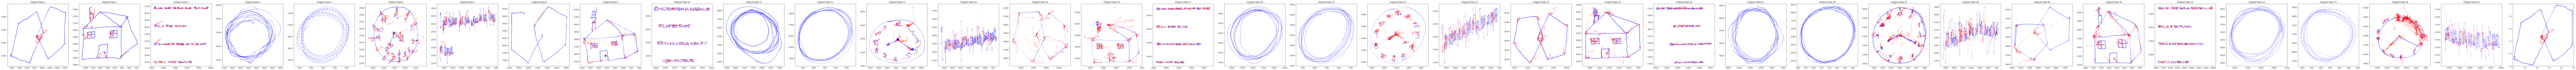

VAE model saved for epoch 100 at vae_models\epoch_100_modelaaa.h5.


Epoch 101/200: 100%|██████████| 279/279 [00:06<00:00, 44.61batch/s, Generator Loss=3.36e-5, Reconstruction Loss=3.36e-5, KL Loss=3.83]  


Epoch 101: Generator Loss = 0.000074, Reconstruction Loss = 0.000074, KL Divergence Loss = 3.784333


Epoch 102/200: 100%|██████████| 279/279 [00:05<00:00, 46.96batch/s, Generator Loss=3.62e-5, Reconstruction Loss=3.62e-5, KL Loss=3.87]  


Epoch 102: Generator Loss = 0.000054, Reconstruction Loss = 0.000054, KL Divergence Loss = 3.887141


Epoch 103/200: 100%|██████████| 279/279 [00:05<00:00, 47.38batch/s, Generator Loss=4.26e-5, Reconstruction Loss=4.26e-5, KL Loss=3.87]  


Epoch 103: Generator Loss = 0.000089, Reconstruction Loss = 0.000089, KL Divergence Loss = 3.896260


Epoch 104/200: 100%|██████████| 279/279 [00:05<00:00, 47.04batch/s, Generator Loss=2.89e-5, Reconstruction Loss=2.89e-5, KL Loss=3.79]  


Epoch 104: Generator Loss = 0.000080, Reconstruction Loss = 0.000080, KL Divergence Loss = 3.896116


Epoch 105/200: 100%|██████████| 279/279 [00:06<00:00, 44.68batch/s, Generator Loss=2.89e-5, Reconstruction Loss=2.89e-5, KL Loss=3.91]  


Epoch 105: Generator Loss = 0.000096, Reconstruction Loss = 0.000096, KL Divergence Loss = 3.904646


Epoch 106/200: 100%|██████████| 279/279 [00:06<00:00, 45.96batch/s, Generator Loss=3.07e-5, Reconstruction Loss=3.07e-5, KL Loss=3.72]  


Epoch 106: Generator Loss = 0.000186, Reconstruction Loss = 0.000186, KL Divergence Loss = 3.793689


Epoch 107/200: 100%|██████████| 279/279 [00:05<00:00, 47.22batch/s, Generator Loss=2.79e-5, Reconstruction Loss=2.79e-5, KL Loss=3.84]  


Epoch 107: Generator Loss = 0.000055, Reconstruction Loss = 0.000055, KL Divergence Loss = 3.854905


Epoch 108/200: 100%|██████████| 279/279 [00:05<00:00, 46.69batch/s, Generator Loss=2.71e-5, Reconstruction Loss=2.71e-5, KL Loss=3.85]  


Epoch 108: Generator Loss = 0.000062, Reconstruction Loss = 0.000062, KL Divergence Loss = 3.909127


Epoch 109/200: 100%|██████████| 279/279 [00:06<00:00, 45.97batch/s, Generator Loss=2.96e-5, Reconstruction Loss=2.96e-5, KL Loss=3.96]  


Epoch 109: Generator Loss = 0.000061, Reconstruction Loss = 0.000061, KL Divergence Loss = 3.939414


Epoch 110/200: 100%|██████████| 279/279 [00:05<00:00, 46.89batch/s, Generator Loss=2.37e-5, Reconstruction Loss=2.37e-5, KL Loss=3.85]  


Epoch 110: Generator Loss = 0.000093, Reconstruction Loss = 0.000093, KL Divergence Loss = 3.919481


Epoch 111/200: 100%|██████████| 279/279 [00:06<00:00, 46.15batch/s, Generator Loss=2.44e-5, Reconstruction Loss=2.44e-5, KL Loss=3.92]  


Epoch 111: Generator Loss = 0.000051, Reconstruction Loss = 0.000051, KL Divergence Loss = 3.953183


Epoch 112/200: 100%|██████████| 279/279 [00:05<00:00, 46.63batch/s, Generator Loss=2.15e-5, Reconstruction Loss=2.15e-5, KL Loss=3.89]  


Epoch 112: Generator Loss = 0.000101, Reconstruction Loss = 0.000101, KL Divergence Loss = 3.935620


Epoch 113/200: 100%|██████████| 279/279 [00:06<00:00, 45.73batch/s, Generator Loss=4.32e-5, Reconstruction Loss=4.32e-5, KL Loss=3.93]  


Epoch 113: Generator Loss = 0.000057, Reconstruction Loss = 0.000057, KL Divergence Loss = 3.932117


Epoch 114/200: 100%|██████████| 279/279 [00:05<00:00, 47.60batch/s, Generator Loss=3.17e-5, Reconstruction Loss=3.17e-5, KL Loss=3.95]  


Epoch 114: Generator Loss = 0.000072, Reconstruction Loss = 0.000072, KL Divergence Loss = 3.934710


Epoch 115/200: 100%|██████████| 279/279 [00:05<00:00, 47.15batch/s, Generator Loss=1.87e-5, Reconstruction Loss=1.87e-5, KL Loss=3.9]   


Epoch 115: Generator Loss = 0.000086, Reconstruction Loss = 0.000086, KL Divergence Loss = 3.921932


Epoch 116/200: 100%|██████████| 279/279 [00:05<00:00, 46.81batch/s, Generator Loss=4.73e-5, Reconstruction Loss=4.73e-5, KL Loss=3.98]  


Epoch 116: Generator Loss = 0.000055, Reconstruction Loss = 0.000055, KL Divergence Loss = 3.943638


Epoch 117/200: 100%|██████████| 279/279 [00:06<00:00, 46.29batch/s, Generator Loss=2.84e-5, Reconstruction Loss=2.84e-5, KL Loss=3.98]  


Epoch 117: Generator Loss = 0.000058, Reconstruction Loss = 0.000058, KL Divergence Loss = 3.971704


Epoch 118/200: 100%|██████████| 279/279 [00:05<00:00, 46.94batch/s, Generator Loss=7.08e-5, Reconstruction Loss=7.08e-5, KL Loss=3.88]  


Epoch 118: Generator Loss = 0.000143, Reconstruction Loss = 0.000143, KL Divergence Loss = 3.933805


Epoch 119/200: 100%|██████████| 279/279 [00:05<00:00, 47.05batch/s, Generator Loss=2.98e-5, Reconstruction Loss=2.98e-5, KL Loss=3.85]  


Epoch 119: Generator Loss = 0.000076, Reconstruction Loss = 0.000076, KL Divergence Loss = 3.924548


Epoch 120/200: 100%|██████████| 279/279 [00:05<00:00, 47.50batch/s, Generator Loss=2.74e-5, Reconstruction Loss=2.74e-5, KL Loss=3.81]  


Epoch 120: Generator Loss = 0.000153, Reconstruction Loss = 0.000153, KL Divergence Loss = 3.825783


Epoch 121/200: 100%|██████████| 279/279 [00:05<00:00, 47.16batch/s, Generator Loss=3.23e-5, Reconstruction Loss=3.23e-5, KL Loss=3.98]  


Epoch 121: Generator Loss = 0.000036, Reconstruction Loss = 0.000036, KL Divergence Loss = 3.897239


Epoch 122/200: 100%|██████████| 279/279 [00:05<00:00, 46.98batch/s, Generator Loss=1.81e-5, Reconstruction Loss=1.81e-5, KL Loss=3.92]  


Epoch 122: Generator Loss = 0.000060, Reconstruction Loss = 0.000060, KL Divergence Loss = 3.928704


Epoch 123/200: 100%|██████████| 279/279 [00:05<00:00, 47.17batch/s, Generator Loss=2.39e-5, Reconstruction Loss=2.39e-5, KL Loss=3.88]  


Epoch 123: Generator Loss = 0.000049, Reconstruction Loss = 0.000049, KL Divergence Loss = 3.955618


Epoch 124/200: 100%|██████████| 279/279 [00:05<00:00, 47.56batch/s, Generator Loss=2.72e-5, Reconstruction Loss=2.72e-5, KL Loss=3.97]  


Epoch 124: Generator Loss = 0.000056, Reconstruction Loss = 0.000056, KL Divergence Loss = 3.949950


Epoch 125/200: 100%|██████████| 279/279 [00:05<00:00, 46.68batch/s, Generator Loss=4.18e-5, Reconstruction Loss=4.18e-5, KL Loss=3.91]  


Epoch 125: Generator Loss = 0.000055, Reconstruction Loss = 0.000055, KL Divergence Loss = 3.965565


Epoch 126/200: 100%|██████████| 279/279 [00:06<00:00, 46.24batch/s, Generator Loss=3.3e-5, Reconstruction Loss=3.3e-5, KL Loss=3.92]    


Epoch 126: Generator Loss = 0.000046, Reconstruction Loss = 0.000046, KL Divergence Loss = 3.972893


Epoch 127/200: 100%|██████████| 279/279 [00:05<00:00, 47.02batch/s, Generator Loss=3.73e-5, Reconstruction Loss=3.73e-5, KL Loss=3.97]  


Epoch 127: Generator Loss = 0.000054, Reconstruction Loss = 0.000054, KL Divergence Loss = 3.984167


Epoch 128/200: 100%|██████████| 279/279 [00:05<00:00, 47.06batch/s, Generator Loss=2.45e-5, Reconstruction Loss=2.45e-5, KL Loss=3.94]  


Epoch 128: Generator Loss = 0.000063, Reconstruction Loss = 0.000063, KL Divergence Loss = 3.966888


Epoch 129/200: 100%|██████████| 279/279 [00:06<00:00, 45.43batch/s, Generator Loss=4.4e-5, Reconstruction Loss=4.4e-5, KL Loss=3.87]    


Epoch 129: Generator Loss = 0.000063, Reconstruction Loss = 0.000063, KL Divergence Loss = 3.941678


Epoch 130/200: 100%|██████████| 279/279 [00:06<00:00, 46.00batch/s, Generator Loss=4.22e-5, Reconstruction Loss=4.22e-5, KL Loss=3.98]  


Epoch 130: Generator Loss = 0.000049, Reconstruction Loss = 0.000049, KL Divergence Loss = 3.953278


Epoch 131/200: 100%|██████████| 279/279 [00:05<00:00, 47.03batch/s, Generator Loss=2.98e-5, Reconstruction Loss=2.98e-5, KL Loss=3.91]  


Epoch 131: Generator Loss = 0.000073, Reconstruction Loss = 0.000073, KL Divergence Loss = 3.945455


Epoch 132/200: 100%|██████████| 279/279 [00:06<00:00, 46.31batch/s, Generator Loss=2.23e-5, Reconstruction Loss=2.23e-5, KL Loss=3.82]  


Epoch 132: Generator Loss = 0.000081, Reconstruction Loss = 0.000081, KL Divergence Loss = 3.901612


Epoch 133/200: 100%|██████████| 279/279 [00:06<00:00, 46.38batch/s, Generator Loss=2.94e-5, Reconstruction Loss=2.94e-5, KL Loss=3.88]  


Epoch 133: Generator Loss = 0.000050, Reconstruction Loss = 0.000050, KL Divergence Loss = 3.925861


Epoch 134/200: 100%|██████████| 279/279 [00:05<00:00, 46.71batch/s, Generator Loss=0.000126, Reconstruction Loss=0.000126, KL Loss=3.98]


Epoch 134: Generator Loss = 0.000051, Reconstruction Loss = 0.000051, KL Divergence Loss = 3.941213


Epoch 135/200: 100%|██████████| 279/279 [00:05<00:00, 46.62batch/s, Generator Loss=3.37e-5, Reconstruction Loss=3.37e-5, KL Loss=3.87]  


Epoch 135: Generator Loss = 0.000089, Reconstruction Loss = 0.000089, KL Divergence Loss = 3.900065


Epoch 136/200: 100%|██████████| 279/279 [00:06<00:00, 45.85batch/s, Generator Loss=1.83e-5, Reconstruction Loss=1.83e-5, KL Loss=3.88]  


Epoch 136: Generator Loss = 0.000058, Reconstruction Loss = 0.000058, KL Divergence Loss = 3.881667


Epoch 137/200: 100%|██████████| 279/279 [00:05<00:00, 47.07batch/s, Generator Loss=1.52e-5, Reconstruction Loss=1.52e-5, KL Loss=3.97]  


Epoch 137: Generator Loss = 0.000035, Reconstruction Loss = 0.000035, KL Divergence Loss = 3.927186


Epoch 138/200: 100%|██████████| 279/279 [00:05<00:00, 46.68batch/s, Generator Loss=2.61e-5, Reconstruction Loss=2.61e-5, KL Loss=3.91]  


Epoch 138: Generator Loss = 0.000051, Reconstruction Loss = 0.000051, KL Divergence Loss = 3.952270


Epoch 139/200: 100%|██████████| 279/279 [00:05<00:00, 47.04batch/s, Generator Loss=2.1e-5, Reconstruction Loss=2.1e-5, KL Loss=3.95]    


Epoch 139: Generator Loss = 0.000039, Reconstruction Loss = 0.000039, KL Divergence Loss = 3.971506


Epoch 140/200: 100%|██████████| 279/279 [00:05<00:00, 47.14batch/s, Generator Loss=1.22e-5, Reconstruction Loss=1.22e-5, KL Loss=4.01]  


Epoch 140: Generator Loss = 0.000031, Reconstruction Loss = 0.000031, KL Divergence Loss = 4.002407


Epoch 141/200: 100%|██████████| 279/279 [00:05<00:00, 47.01batch/s, Generator Loss=3.51e-5, Reconstruction Loss=3.51e-5, KL Loss=3.97]  


Epoch 141: Generator Loss = 0.000061, Reconstruction Loss = 0.000061, KL Divergence Loss = 3.975672


Epoch 142/200: 100%|██████████| 279/279 [00:05<00:00, 47.46batch/s, Generator Loss=1.98e-5, Reconstruction Loss=1.98e-5, KL Loss=4.05]  


Epoch 142: Generator Loss = 0.000034, Reconstruction Loss = 0.000034, KL Divergence Loss = 3.979810


Epoch 143/200: 100%|██████████| 279/279 [00:06<00:00, 46.45batch/s, Generator Loss=3.61e-5, Reconstruction Loss=3.61e-5, KL Loss=3.95]  


Epoch 143: Generator Loss = 0.000055, Reconstruction Loss = 0.000055, KL Divergence Loss = 3.987611


Epoch 144/200: 100%|██████████| 279/279 [00:05<00:00, 46.63batch/s, Generator Loss=5.11e-5, Reconstruction Loss=5.11e-5, KL Loss=3.91]  


Epoch 144: Generator Loss = 0.000062, Reconstruction Loss = 0.000062, KL Divergence Loss = 3.948321


Epoch 145/200: 100%|██████████| 279/279 [00:06<00:00, 46.46batch/s, Generator Loss=1.48e-5, Reconstruction Loss=1.48e-5, KL Loss=3.94]  


Epoch 145: Generator Loss = 0.000053, Reconstruction Loss = 0.000053, KL Divergence Loss = 3.937012


Epoch 146/200: 100%|██████████| 279/279 [00:05<00:00, 46.69batch/s, Generator Loss=1.69e-5, Reconstruction Loss=1.69e-5, KL Loss=3.96]  


Epoch 146: Generator Loss = 0.000050, Reconstruction Loss = 0.000050, KL Divergence Loss = 3.962367


Epoch 147/200: 100%|██████████| 279/279 [00:05<00:00, 47.07batch/s, Generator Loss=3.07e-5, Reconstruction Loss=3.07e-5, KL Loss=3.96]  


Epoch 147: Generator Loss = 0.000042, Reconstruction Loss = 0.000042, KL Divergence Loss = 3.986876


Epoch 148/200: 100%|██████████| 279/279 [00:05<00:00, 47.27batch/s, Generator Loss=2.17e-5, Reconstruction Loss=2.17e-5, KL Loss=3.93]  


Epoch 148: Generator Loss = 0.000048, Reconstruction Loss = 0.000048, KL Divergence Loss = 3.978069


Epoch 149/200: 100%|██████████| 279/279 [00:05<00:00, 46.64batch/s, Generator Loss=1.1e-5, Reconstruction Loss=1.1e-5, KL Loss=3.92]    


Epoch 149: Generator Loss = 0.000049, Reconstruction Loss = 0.000049, KL Divergence Loss = 3.963255


Epoch 150/200: 100%|██████████| 279/279 [00:06<00:00, 45.89batch/s, Generator Loss=3.01e-5, Reconstruction Loss=3.01e-5, KL Loss=3.97]  


Epoch 150: Generator Loss = 0.000041, Reconstruction Loss = 0.000041, KL Divergence Loss = 3.989774


Epoch 151/200: 100%|██████████| 279/279 [00:06<00:00, 45.94batch/s, Generator Loss=1.26e-5, Reconstruction Loss=1.26e-5, KL Loss=3.94]  


Epoch 151: Generator Loss = 0.000050, Reconstruction Loss = 0.000050, KL Divergence Loss = 3.967749


Epoch 152/200: 100%|██████████| 279/279 [00:05<00:00, 47.48batch/s, Generator Loss=1.29e-5, Reconstruction Loss=1.29e-5, KL Loss=3.99]  


Epoch 152: Generator Loss = 0.000052, Reconstruction Loss = 0.000052, KL Divergence Loss = 3.957000


Epoch 153/200: 100%|██████████| 279/279 [00:05<00:00, 46.75batch/s, Generator Loss=1.28e-5, Reconstruction Loss=1.28e-5, KL Loss=3.98]  


Epoch 153: Generator Loss = 0.000032, Reconstruction Loss = 0.000032, KL Divergence Loss = 3.984132


Epoch 154/200: 100%|██████████| 279/279 [00:05<00:00, 46.67batch/s, Generator Loss=3.09e-5, Reconstruction Loss=3.09e-5, KL Loss=3.89]  


Epoch 154: Generator Loss = 0.000057, Reconstruction Loss = 0.000057, KL Divergence Loss = 3.960692


Epoch 155/200: 100%|██████████| 279/279 [00:06<00:00, 45.01batch/s, Generator Loss=1.32e-5, Reconstruction Loss=1.32e-5, KL Loss=3.97]  


Epoch 155: Generator Loss = 0.000047, Reconstruction Loss = 0.000047, KL Divergence Loss = 3.973216


Epoch 156/200: 100%|██████████| 279/279 [00:06<00:00, 45.43batch/s, Generator Loss=2.29e-5, Reconstruction Loss=2.29e-5, KL Loss=3.98]  


Epoch 156: Generator Loss = 0.000037, Reconstruction Loss = 0.000037, KL Divergence Loss = 3.967722


Epoch 157/200: 100%|██████████| 279/279 [00:06<00:00, 45.74batch/s, Generator Loss=1.64e-5, Reconstruction Loss=1.64e-5, KL Loss=3.89]  


Epoch 157: Generator Loss = 0.000052, Reconstruction Loss = 0.000052, KL Divergence Loss = 3.961230


Epoch 158/200: 100%|██████████| 279/279 [00:06<00:00, 42.48batch/s, Generator Loss=9.72e-6, Reconstruction Loss=9.72e-6, KL Loss=3.99]  


Epoch 158: Generator Loss = 0.000032, Reconstruction Loss = 0.000032, KL Divergence Loss = 3.978476


Epoch 159/200: 100%|██████████| 279/279 [00:05<00:00, 49.62batch/s, Generator Loss=3.6e-5, Reconstruction Loss=3.6e-5, KL Loss=4.01]    


Epoch 159: Generator Loss = 0.000032, Reconstruction Loss = 0.000032, KL Divergence Loss = 4.008123


Epoch 160/200: 100%|██████████| 279/279 [00:05<00:00, 52.14batch/s, Generator Loss=1.79e-5, Reconstruction Loss=1.79e-5, KL Loss=3.89]  


Epoch 160: Generator Loss = 0.000083, Reconstruction Loss = 0.000083, KL Divergence Loss = 3.938690


Epoch 161/200: 100%|██████████| 279/279 [00:05<00:00, 55.17batch/s, Generator Loss=1.57e-5, Reconstruction Loss=1.57e-5, KL Loss=3.98]  


Epoch 161: Generator Loss = 0.000047, Reconstruction Loss = 0.000047, KL Divergence Loss = 3.929461


Epoch 162/200: 100%|██████████| 279/279 [00:04<00:00, 56.79batch/s, Generator Loss=1.03e-5, Reconstruction Loss=1.03e-5, KL Loss=3.99]  


Epoch 162: Generator Loss = 0.000028, Reconstruction Loss = 0.000028, KL Divergence Loss = 3.959938


Epoch 163/200: 100%|██████████| 279/279 [00:04<00:00, 56.17batch/s, Generator Loss=9.98e-6, Reconstruction Loss=9.98e-6, KL Loss=3.98]  


Epoch 163: Generator Loss = 0.000027, Reconstruction Loss = 0.000027, KL Divergence Loss = 3.997369


Epoch 164/200: 100%|██████████| 279/279 [00:04<00:00, 56.05batch/s, Generator Loss=2.68e-5, Reconstruction Loss=2.68e-5, KL Loss=3.8]   


Epoch 164: Generator Loss = 0.000076, Reconstruction Loss = 0.000076, KL Divergence Loss = 3.934433


Epoch 165/200: 100%|██████████| 279/279 [00:04<00:00, 55.89batch/s, Generator Loss=1.43e-5, Reconstruction Loss=1.43e-5, KL Loss=3.88]  


Epoch 165: Generator Loss = 0.000083, Reconstruction Loss = 0.000083, KL Divergence Loss = 3.875041


Epoch 166/200: 100%|██████████| 279/279 [00:05<00:00, 55.41batch/s, Generator Loss=1.25e-5, Reconstruction Loss=1.25e-5, KL Loss=3.94]  


Epoch 166: Generator Loss = 0.000033, Reconstruction Loss = 0.000033, KL Divergence Loss = 3.901274


Epoch 167/200: 100%|██████████| 279/279 [00:05<00:00, 55.30batch/s, Generator Loss=2.49e-5, Reconstruction Loss=2.49e-5, KL Loss=3.91]  


Epoch 167: Generator Loss = 0.000027, Reconstruction Loss = 0.000027, KL Divergence Loss = 3.944545


Epoch 168/200: 100%|██████████| 279/279 [00:05<00:00, 55.27batch/s, Generator Loss=2.47e-5, Reconstruction Loss=2.47e-5, KL Loss=3.94]  


Epoch 168: Generator Loss = 0.000041, Reconstruction Loss = 0.000041, KL Divergence Loss = 3.943668


Epoch 169/200: 100%|██████████| 279/279 [00:04<00:00, 56.32batch/s, Generator Loss=2.23e-5, Reconstruction Loss=2.23e-5, KL Loss=3.97]  


Epoch 169: Generator Loss = 0.000035, Reconstruction Loss = 0.000035, KL Divergence Loss = 3.946157


Epoch 170/200: 100%|██████████| 279/279 [00:05<00:00, 55.34batch/s, Generator Loss=2.36e-5, Reconstruction Loss=2.36e-5, KL Loss=3.89]  


Epoch 170: Generator Loss = 0.000053, Reconstruction Loss = 0.000053, KL Divergence Loss = 3.927170


Epoch 171/200: 100%|██████████| 279/279 [00:05<00:00, 52.53batch/s, Generator Loss=9.82e-6, Reconstruction Loss=9.82e-6, KL Loss=3.93]  


Epoch 171: Generator Loss = 0.000036, Reconstruction Loss = 0.000036, KL Divergence Loss = 3.931638


Epoch 172/200: 100%|██████████| 279/279 [00:04<00:00, 55.93batch/s, Generator Loss=1.83e-5, Reconstruction Loss=1.83e-5, KL Loss=3.96]  


Epoch 172: Generator Loss = 0.000034, Reconstruction Loss = 0.000034, KL Divergence Loss = 3.951215


Epoch 173/200: 100%|██████████| 279/279 [00:04<00:00, 55.91batch/s, Generator Loss=1.95e-5, Reconstruction Loss=1.95e-5, KL Loss=3.87]  


Epoch 173: Generator Loss = 0.000049, Reconstruction Loss = 0.000049, KL Divergence Loss = 3.941870


Epoch 174/200: 100%|██████████| 279/279 [00:04<00:00, 56.22batch/s, Generator Loss=2.06e-5, Reconstruction Loss=2.06e-5, KL Loss=3.97]  


Epoch 174: Generator Loss = 0.000034, Reconstruction Loss = 0.000034, KL Divergence Loss = 3.947875


Epoch 175/200: 100%|██████████| 279/279 [00:05<00:00, 55.33batch/s, Generator Loss=1.63e-5, Reconstruction Loss=1.63e-5, KL Loss=3.98]  


Epoch 175: Generator Loss = 0.000050, Reconstruction Loss = 0.000050, KL Divergence Loss = 3.934903


Epoch 176/200: 100%|██████████| 279/279 [00:05<00:00, 55.50batch/s, Generator Loss=1.03e-5, Reconstruction Loss=1.03e-5, KL Loss=3.92]  


Epoch 176: Generator Loss = 0.000034, Reconstruction Loss = 0.000034, KL Divergence Loss = 3.932316


Epoch 177/200: 100%|██████████| 279/279 [00:04<00:00, 55.89batch/s, Generator Loss=9.26e-6, Reconstruction Loss=9.26e-6, KL Loss=3.97]  


Epoch 177: Generator Loss = 0.000041, Reconstruction Loss = 0.000041, KL Divergence Loss = 3.945900


Epoch 178/200: 100%|██████████| 279/279 [00:04<00:00, 56.00batch/s, Generator Loss=1.02e-5, Reconstruction Loss=1.02e-5, KL Loss=3.95]  


Epoch 178: Generator Loss = 0.000035, Reconstruction Loss = 0.000035, KL Divergence Loss = 3.953811


Epoch 179/200: 100%|██████████| 279/279 [00:05<00:00, 55.18batch/s, Generator Loss=6.76e-5, Reconstruction Loss=6.76e-5, KL Loss=3.79]  


Epoch 179: Generator Loss = 0.000141, Reconstruction Loss = 0.000141, KL Divergence Loss = 3.850599


Epoch 180/200: 100%|██████████| 279/279 [00:05<00:00, 55.63batch/s, Generator Loss=1.02e-5, Reconstruction Loss=1.02e-5, KL Loss=3.84]  


Epoch 180: Generator Loss = 0.000039, Reconstruction Loss = 0.000039, KL Divergence Loss = 3.852151


Epoch 181/200: 100%|██████████| 279/279 [00:05<00:00, 55.69batch/s, Generator Loss=9.62e-6, Reconstruction Loss=9.62e-6, KL Loss=3.95]  


Epoch 181: Generator Loss = 0.000023, Reconstruction Loss = 0.000023, KL Divergence Loss = 3.931144


Epoch 182/200: 100%|██████████| 279/279 [00:05<00:00, 55.30batch/s, Generator Loss=1.36e-5, Reconstruction Loss=1.36e-5, KL Loss=3.92]  


Epoch 182: Generator Loss = 0.000028, Reconstruction Loss = 0.000028, KL Divergence Loss = 3.965030


Epoch 183/200: 100%|██████████| 279/279 [00:05<00:00, 54.85batch/s, Generator Loss=8.1e-6, Reconstruction Loss=8.1e-6, KL Loss=3.92]    


Epoch 183: Generator Loss = 0.000033, Reconstruction Loss = 0.000033, KL Divergence Loss = 3.951850


Epoch 184/200: 100%|██████████| 279/279 [00:04<00:00, 56.09batch/s, Generator Loss=8.03e-6, Reconstruction Loss=8.03e-6, KL Loss=3.92] 


Epoch 184: Generator Loss = 0.000028, Reconstruction Loss = 0.000028, KL Divergence Loss = 3.979145


Epoch 185/200: 100%|██████████| 279/279 [00:04<00:00, 56.12batch/s, Generator Loss=1.47e-5, Reconstruction Loss=1.47e-5, KL Loss=3.99]


Epoch 185: Generator Loss = 0.000021, Reconstruction Loss = 0.000021, KL Divergence Loss = 4.017718


Epoch 186/200: 100%|██████████| 279/279 [00:04<00:00, 56.46batch/s, Generator Loss=1.35e-5, Reconstruction Loss=1.35e-5, KL Loss=3.97]  


Epoch 186: Generator Loss = 0.000045, Reconstruction Loss = 0.000045, KL Divergence Loss = 3.990564


Epoch 187/200: 100%|██████████| 279/279 [00:04<00:00, 56.29batch/s, Generator Loss=8.4e-6, Reconstruction Loss=8.4e-6, KL Loss=3.98]    


Epoch 187: Generator Loss = 0.000032, Reconstruction Loss = 0.000032, KL Divergence Loss = 3.976370


Epoch 188/200: 100%|██████████| 279/279 [00:05<00:00, 54.56batch/s, Generator Loss=1.22e-5, Reconstruction Loss=1.22e-5, KL Loss=3.94]


Epoch 188: Generator Loss = 0.000024, Reconstruction Loss = 0.000024, KL Divergence Loss = 3.999472


Epoch 189/200: 100%|██████████| 279/279 [00:05<00:00, 55.79batch/s, Generator Loss=8.72e-6, Reconstruction Loss=8.72e-6, KL Loss=3.98] 


Epoch 189: Generator Loss = 0.000035, Reconstruction Loss = 0.000035, KL Divergence Loss = 3.986177


Epoch 190/200: 100%|██████████| 279/279 [00:04<00:00, 55.83batch/s, Generator Loss=3e-5, Reconstruction Loss=3e-5, KL Loss=3.97]        


Epoch 190: Generator Loss = 0.000039, Reconstruction Loss = 0.000039, KL Divergence Loss = 3.989141


Epoch 191/200: 100%|██████████| 279/279 [00:05<00:00, 55.55batch/s, Generator Loss=1.7e-5, Reconstruction Loss=1.7e-5, KL Loss=3.96]    


Epoch 191: Generator Loss = 0.000046, Reconstruction Loss = 0.000046, KL Divergence Loss = 3.961576


Epoch 192/200: 100%|██████████| 279/279 [00:04<00:00, 56.47batch/s, Generator Loss=1.25e-5, Reconstruction Loss=1.25e-5, KL Loss=3.84]  


Epoch 192: Generator Loss = 0.000046, Reconstruction Loss = 0.000046, KL Divergence Loss = 3.928829


Epoch 193/200: 100%|██████████| 279/279 [00:04<00:00, 55.93batch/s, Generator Loss=1.41e-5, Reconstruction Loss=1.41e-5, KL Loss=3.88]  


Epoch 193: Generator Loss = 0.000037, Reconstruction Loss = 0.000037, KL Divergence Loss = 3.932076


Epoch 194/200: 100%|██████████| 279/279 [00:04<00:00, 56.02batch/s, Generator Loss=8.66e-6, Reconstruction Loss=8.66e-6, KL Loss=3.89]  


Epoch 194: Generator Loss = 0.000032, Reconstruction Loss = 0.000032, KL Divergence Loss = 3.956901


Epoch 195/200: 100%|██████████| 279/279 [00:05<00:00, 55.57batch/s, Generator Loss=1.33e-5, Reconstruction Loss=1.33e-5, KL Loss=3.79]  


Epoch 195: Generator Loss = 0.000097, Reconstruction Loss = 0.000097, KL Divergence Loss = 3.862293


Epoch 196/200: 100%|██████████| 279/279 [00:05<00:00, 55.47batch/s, Generator Loss=8.44e-6, Reconstruction Loss=8.44e-6, KL Loss=3.84]  


Epoch 196: Generator Loss = 0.000026, Reconstruction Loss = 0.000026, KL Divergence Loss = 3.887078


Epoch 197/200: 100%|██████████| 279/279 [00:05<00:00, 54.30batch/s, Generator Loss=1.1e-5, Reconstruction Loss=1.1e-5, KL Loss=3.92]  


Epoch 197: Generator Loss = 0.000018, Reconstruction Loss = 0.000018, KL Divergence Loss = 3.944155


Epoch 198/200: 100%|██████████| 279/279 [00:05<00:00, 54.14batch/s, Generator Loss=8.63e-6, Reconstruction Loss=8.63e-6, KL Loss=4.01]


Epoch 198: Generator Loss = 0.000018, Reconstruction Loss = 0.000018, KL Divergence Loss = 3.980432


Epoch 199/200: 100%|██████████| 279/279 [00:04<00:00, 56.27batch/s, Generator Loss=8.74e-6, Reconstruction Loss=8.74e-6, KL Loss=3.94]  


Epoch 199: Generator Loss = 0.000037, Reconstruction Loss = 0.000037, KL Divergence Loss = 3.956750


Epoch 200/200: 100%|██████████| 279/279 [00:05<00:00, 55.17batch/s, Generator Loss=1.04e-5, Reconstruction Loss=1.04e-5, KL Loss=3.98]  


Epoch 200: Generator Loss = 0.000022, Reconstruction Loss = 0.000022, KL Divergence Loss = 3.981031


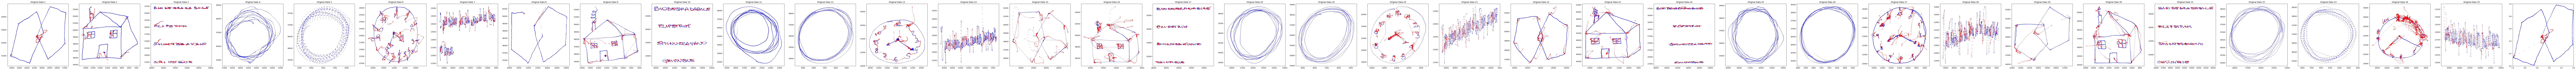

VAE model saved for epoch 200 at vae_models\epoch_200_modelaaa.h5.
Final VAE model saved.


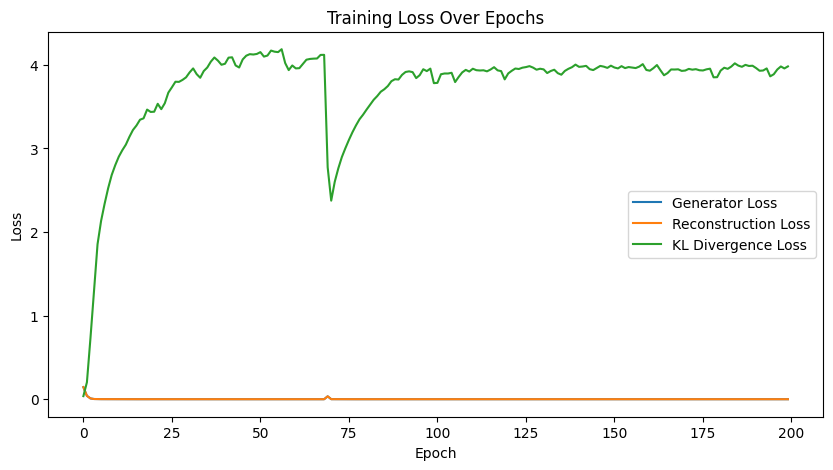

<Figure size 640x480 with 0 Axes>

In [33]:
#Cell 8
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + model.beta * total_kl_loss + 0.1 * discriminator_loss
        else:
            generator_loss = reconstruction_loss + model.beta * total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 200
lstm_interval = 50
epochs = 200
visual_per_num_epoch = 100
num_augmented_files = 1

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

save_dir = "vae_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train LSTM every `lstm_interval` epochs after `vae_epochs`
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)
            generated_data = tf.expand_dims(augmented_data, axis=0)
            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')


    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)



    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")



    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)

        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6*(num_augmented_files + len(original_data_frames)), 6))

        for i, original_data in enumerate(original_data_frames):
            original_on_paper = original_data[original_data['pen_status'] == 1]
            original_in_air = original_data[original_data['pen_status'] == 0]

            axs[i].scatter(original_on_paper['y'], original_on_paper['x'], c='b', s=1, label='On Paper')
            axs[i].scatter(original_in_air['y'], original_in_air['x'], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].invert_xaxis()

        # Set consistent axis limits for square aspect ratio for both original and augmented data
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]

            axs[i+len(original_data_frames)].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')
            axs[i+len(original_data_frames)].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')
            axs[i+len(original_data_frames)].invert_xaxis()
            axs[i+len(original_data_frames)].set_xlim(y_max, y_min)
            axs[i+len(original_data_frames)].set_ylim(x_min, x_max)

        plt.tight_layout()
        plt.show()
        # Save VAE model after each epoch, directly into the `vae_models` folder
        model_save_path = os.path.join(save_dir, f"epoch_{epoch+1}_modelaaa.h5")
        vae.save(model_save_path)
        print(f"VAE model saved for epoch {epoch+1} at {model_save_path}.")

# Final output and plots
plt.ioff()
plt.show()

vae.save('pentab_saved_model.h5')
print("Final VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pretrained VAE model loaded.


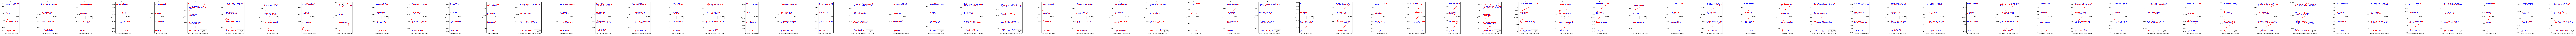

In [45]:
# Cell 9: Plot the original data before imputation using original_data_frames from Cell 2, rotated 90 degrees to the left

# Load the pretrained VAE model
with custom_object_scope({'VAE': VAE}):
    vae_pretrained = load_model('vae_models/epoch_200_modelaaa.h5')
print("Pretrained VAE model loaded.")

# Base latent variability settings
base_latent_variability = 100.0
latent_variability_range = (0.99, 1.01)
num_augmented_files = 35


# Generate augmented data using the pretrained model
augmented_datasets = generate_augmented_data(vae_pretrained, num_augmented_files, avg_data_points, processed_data, 
                                             base_latent_variability, latent_variability_range)

# Calculate actual latent variabilities and lengths used
latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
augmented_lengths = [len(data) for data in augmented_datasets]

# Function to visualize augmented data after inverse scaling
def repeat_backwards(original_paa, augmented_length):
    # Calculate how many rows need to be filled
    repeat_count = augmented_length - len(original_paa)

    # If no rows need to be filled, return the original data
    if repeat_count <= 0:
        return original_paa

    # Repeat the original data backwards row by row
    backwards_rows = np.empty((0, original_paa.shape[1]))
    for i in range(repeat_count):
        row_to_repeat = original_paa[-(i + 1)]  # Get the i-th row from the end
        backwards_rows = np.vstack((backwards_rows, row_to_repeat))

    # Append the backward-repeated rows to the original data
    return np.vstack((original_paa, backwards_rows))

# Updated visualization function with the new filling method
def visualize_augmented_data(augmented_datasets, scalers, original_data_frames, axs):
    all_augmented_data = []  # List to store augmented datasets after scaling back

    for i, (augmented_data, scaler, original_df) in enumerate(zip(augmented_datasets, scalers, original_data_frames)):
        # Inverse transform the augmented data
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        
        # Round to integers
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        
        # Get pen status from augmented data
        pen_status = augmented_data[:, 3].astype(int)
        
        # Prepare pressure, azimuth, altitude data from original data
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        # If augmented data is longer, fill the original data by repeating values backwards
        if len(augmented_data) > len(original_paa):
            original_paa = repeat_backwards(original_paa, len(augmented_data))
        
        # Round pressure, azimuth, altitude to integers
        original_paa_int = np.rint(original_paa).astype(int)
        
        # Combine all data
        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))
        
        # Store the augmented data for later use
        all_augmented_data.append(augmented_data_original_scale)
        
        # Visualization of the augmented data (after inverse scaling)
        augmented_on_paper = augmented_data_original_scale[augmented_data_original_scale[:, 3] == 1]
        augmented_in_air = augmented_data_original_scale[augmented_data_original_scale[:, 3] == 0]

        # Scatter plot for the augmented data, with rotated axes
        axs[i + len(original_data_frames)].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')  # y -> x, x -> y
        axs[i + len(original_data_frames)].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')  # y -> x, x -> y
        axs[i + len(original_data_frames)].set_title(f'Augmented Data {i + 1}')
        axs[i + len(original_data_frames)].set_xlabel('y')  # Previously 'x'
        axs[i + len(original_data_frames)].set_ylabel('x')  # Previously 'y'
        axs[i + len(original_data_frames)].set_aspect('equal')
        axs[i + len(original_data_frames)].invert_xaxis()  # Flip the horizontal axis (y-axis)
        axs[i + len(original_data_frames)].legend()

    return all_augmented_data  # Return the list of augmented datasets after scaling back


# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6 * (num_augmented_files + len(original_data_frames)), 6))

# Plot the original data before imputation, with a 90-degree left rotation and horizontal flip
for i, original_data in enumerate(original_data_frames):  # Use original_data_frames for raw data visualization
    original_on_paper = original_data[original_data['pen_status'] == 1]
    original_in_air = original_data[original_data['pen_status'] == 0]
    
    # Scatter plot for the original data (before imputation), with rotated axes
    axs[i].scatter(original_on_paper['y'], original_on_paper['x'], c='b', s=1, label='On Paper')  # y -> x, x -> y
    axs[i].scatter(original_in_air['y'], original_in_air['x'], c='r', s=1, label='In Air')  # y -> x, x -> y
    axs[i].set_title(f'Original Data {i + 1}')
    axs[i].set_xlabel('y')  # Previously 'x'
    axs[i].set_ylabel('x')  # Previously 'y'
    axs[i].set_aspect('equal')
    axs[i].legend()
    
    # Flip the horizontal axis (y-axis)
    axs[i].invert_xaxis()  # This reverses the 'y' axis to flip the plot horizontally

# Set consistent axis limits for square aspect ratio for both original and augmented data
x_min = min(data['x'].min() for data in original_data_frames)
x_max = max(data['x'].max() for data in original_data_frames)
y_min = min(data['y'].min() for data in original_data_frames)
y_max = max(data['y'].max() for data in original_data_frames)

# Plot the augmented data with the same 90-degree left rotation and horizontal flip
all_augmented_data = visualize_augmented_data(augmented_datasets, scalers, original_data_frames, axs)

plt.tight_layout()
plt.show()

In [46]:
import os
import numpy as np


# Cell 10 (modified to adjust timestamp)


def download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, original_filenames, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        # Inverse transform the augmented data
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        
        # Round to integers
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        
        # Get pen status from augmented data
        pen_status = augmented_data[:, 3].astype(int)
        
        # Prepare pressure, azimuth, altitude data
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        if len(augmented_data) > len(original_paa):
            original_paa = repeat_backwards(original_paa, len(augmented_data))
        
        # Round pressure, azimuth, altitude to integers
        original_paa_int = np.rint(original_paa).astype(int)
        
        # Generate new timestamps: start at 0, alternately incrementing by 7 and 8
        new_timestamps = np.zeros(len(augmented_data), dtype=int)
        increment_sequence = [7, 8]
        current_time = 0
        for idx in range(len(augmented_data)):
            new_timestamps[idx] = current_time
            current_time += increment_sequence[idx % 2]  # Alternate between 7 and 8

        # Replace the timestamp in the 3rd column of augmented_xyz_int
        augmented_xyz_int[:, 2] = new_timestamps

        # Combine all data: XYZ, pen status, pressure, azimuth, altitude
        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        # Construct the new file name to match the original file name
        augmented_filename = f"augmented_{original_filename}"
        augmented_file_path = os.path.join(directory, augmented_filename)

        # Save the augmented data to a file
        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

# Example call to the function
download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, input_filenames)

# Add this diagnostic print statement after generating augmented_datasets
print("Shapes of augmented datasets:")
for i, aug_data in enumerate(augmented_datasets):
    print(f"Shape of augmented dataset {i+1}: {aug_data.shape}")


Augmented data saved to augmented_data\augmented_u00001s00001_hw00003.svc
Shape of augmented data for u00001s00001_hw00003.svc: (4680, 7)
Augmented data saved to augmented_data\augmented_u00002s00001_hw00003.svc
Shape of augmented data for u00002s00001_hw00003.svc: (4444, 7)
Augmented data saved to augmented_data\augmented_u00003s00001_hw00003.svc
Shape of augmented data for u00003s00001_hw00003.svc: (4236, 7)
Augmented data saved to augmented_data\augmented_u00004s00001_hw00003.svc
Shape of augmented data for u00004s00001_hw00003.svc: (5519, 7)
Augmented data saved to augmented_data\augmented_u00005s00001_hw00003.svc
Shape of augmented data for u00005s00001_hw00003.svc: (4328, 7)
Augmented data saved to augmented_data\augmented_u00006s00001_hw00003.svc
Shape of augmented data for u00006s00001_hw00003.svc: (6895, 7)
Augmented data saved to augmented_data\augmented_u00007s00001_hw00003.svc
Shape of augmented data for u00007s00001_hw00003.svc: (5070, 7)
Augmented data saved to augmented_

In [47]:
# Cell 11 NRMSE
def calculate_nrmse(original, predicted):

    if original.shape != predicted.shape:
        raise ValueError("The shapes of the original and predicted datasets must match.")
    
    mse = np.mean((original - predicted) ** 2)
    rmse = np.sqrt(mse)
    nrmse = rmse / (np.max(original) - np.min(original))
    
    return nrmse

# Example usage:
nrmse_values = []

# Using all_augmented_data from Cell 9
for i, (original, augmented) in enumerate(zip(data_frames, all_augmented_data)):
    original_array = original[['x', 'y', 'timestamp', 'pen_status']].values
    augmented_array = augmented[:, :4]  # Assuming first 4 columns match original data structure

    nrmse = calculate_nrmse(original_array, augmented_array)
    nrmse_values.append(nrmse)

# Print results
for i, nrmse in enumerate(nrmse_values):
    print(f"NRMSE for dataset {i+1}: {nrmse:.4f}")

# Calculate average NRMSE
average_nrmse = np.mean(nrmse_values)
print(f"Average NRMSE: {average_nrmse:.4f}")

NRMSE for dataset 1: 0.0026
NRMSE for dataset 2: 0.0024
NRMSE for dataset 3: 0.0025
NRMSE for dataset 4: 0.0025
NRMSE for dataset 5: 0.0026
NRMSE for dataset 6: 0.0028
NRMSE for dataset 7: 0.0031
NRMSE for dataset 8: 0.0023
NRMSE for dataset 9: 0.0028
NRMSE for dataset 10: 0.0028
NRMSE for dataset 11: 0.0026
NRMSE for dataset 12: 0.0022
NRMSE for dataset 13: 0.0018
NRMSE for dataset 14: 0.0025
NRMSE for dataset 15: 0.0023
NRMSE for dataset 16: 0.0023
NRMSE for dataset 17: 0.0022
NRMSE for dataset 18: 0.0023
NRMSE for dataset 19: 0.0025
NRMSE for dataset 20: 0.0027
NRMSE for dataset 21: 0.0031
NRMSE for dataset 22: 0.0021
NRMSE for dataset 23: 0.0017
NRMSE for dataset 24: 0.0022
NRMSE for dataset 25: 0.0024
NRMSE for dataset 26: 0.0024
NRMSE for dataset 27: 0.0028
NRMSE for dataset 28: 0.0028
NRMSE for dataset 29: 0.0023
NRMSE for dataset 30: 0.0028
NRMSE for dataset 31: 0.0030
NRMSE for dataset 32: 0.0025
NRMSE for dataset 33: 0.0025
NRMSE for dataset 34: 0.0022
NRMSE for dataset 35: 0

In [12]:
# Cell 12 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_lstm_classifier(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def prepare_data_for_lstm(real_data, synthetic_data):
    # Determine the number of features to use (minimum of real and synthetic data)
    n_features = min(real_data.shape[1], synthetic_data.shape[1])
    
    # Trim the features to match
    real_data_trimmed = real_data[:, :n_features]
    synthetic_data_trimmed = synthetic_data[:, :n_features]
    
    X = np.vstack((real_data_trimmed, synthetic_data_trimmed))
    y = np.concatenate((np.ones(len(real_data)), np.zeros(len(synthetic_data))))
    return X, y

def post_hoc_discriminative_score(real_data, synthetic_data, n_splits=10):
    X, y = prepare_data_for_lstm(real_data, synthetic_data)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Reshape the data for LSTM input (samples, timesteps, features)
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        model = create_lstm_classifier((1, X_train.shape[2]))
        model.fit(X_train, y_train, epochs=3, batch_size=256, verbose=1)

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    return mean_accuracy, std_accuracy

# Assuming 'processed_data' contains the real data and 'augmented_datasets' contains the synthetic data
real_data = np.concatenate(processed_data, axis=0)
synthetic_data = np.concatenate(augmented_datasets, axis=0)

print(f"Real data shape: {real_data.shape}")
print(f"Synthetic data shape: {synthetic_data.shape}")

mean_accuracy, std_accuracy = post_hoc_discriminative_score(real_data, synthetic_data)

print(f"\nPost-Hoc Discriminative Score Results:")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

# Interpret the results
if abs(mean_accuracy - 0.5) < 0.05:
    print("\nThe synthetic data is effectively indistinguishable from real data.")
elif mean_accuracy > 0.55:
    print("\nThe classifier can distinguish between real and synthetic data with some accuracy.")
    print("This suggests that the synthetic data may not fully capture all characteristics of the real data.")
else:
    print("\nThe classifier performs worse than random guessing.")
    print("This might indicate issues with the classification process or highly varied data.")

Real data shape: (3910, 4)
Synthetic data shape: (3910, 7)
Epoch 1/3


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4866 - loss: 0.6933
Epoch 2/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4918 - loss: 0.6931 
Epoch 3/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5083 - loss: 0.6931 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/3


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5036 - loss: 0.6932
Epoch 2/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5050 - loss: 0.6931
Epoch 3/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4977 - loss: 0.6931
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Epoch 1/3


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5038 - loss: 0.6932
Epoch 2/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5153 - loss: 0.6931 
Epoch 3/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5042 - loss: 0.6932
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/3


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5025 - loss: 0.6932
Epoch 2/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5033 - loss: 0.6931
Epoch 3/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4967 - loss: 0.6933
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/3


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4997 - loss: 0.6932
Epoch 2/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5017 - loss: 0.6931
Epoch 3/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5001 - loss: 0.6932 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/3


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [14]:
# Cell 13 Post Hoc Predictive Score
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from keras.callbacks import Callback
from tqdm import tqdm

# Step 1: Prepare Data
def prepare_data(df, time_steps=5):
    data = df[['x', 'y']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    # Create sequences of length `time_steps`
    X, y = [], []
    for i in range(len(data_scaled) - time_steps):
        X.append(data_scaled[i:i+time_steps])
        y.append(data_scaled[i+time_steps])
    
    return np.array(X), np.array(y), scaler

# Example usage
X, y, scaler = prepare_data(data_frames[0])

# Custom callback for progress bar
class CustomCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc="Training Progress")

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)

    def on_train_end(self, logs=None):
        self.progress_bar.close()

# Step 2: Define the LSTM Model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Adding dropout to introduce randomness
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(2))  # Predict x and y
    model.compile(optimizer='adam', loss='mse')
    return model

# Step 3: Evaluate Model Function
def evaluate_model(model, X_test, y_test, scaler):
    # Predict and inverse transform
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)
    
    # Compute MAPE for each test sample
    mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
    print(f"\nMAPE: {mape * 100:.2f}%")
    
    # Interpretation of MAPE
    if mape < 0.1:
        interpretation = "Excellent prediction"
    elif mape < 0.2:
        interpretation = "Good prediction"
    elif mape < 0.5:
        interpretation = "Fair prediction"
    else:
        interpretation = "Poor prediction"
    
    print(f"Interpretation: {interpretation}")
    
    return mape

# Step 4: K-Fold Cross-Validation Implementation
kf = KFold(n_splits=10, shuffle=True, random_state=np.random.randint(1000))  # 10-fold cross-validation

mape_values = []
for train_index, test_index in kf.split(X):
    # Split data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=5, batch_size=512, verbose=0, callbacks=[CustomCallback()])
    
    # Evaluate the model and store MAPE
    mape = evaluate_model(model, X_test, y_test, scaler)
    mape_values.append(mape)

# Step 5: Calculate Mean and Standard Deviation of MAPE
mean_mape = np.mean(mape_values)
std_mape = np.std(mape_values)

print(f"\nMean MAPE: {mean_mape * 100:.2f}%")
print(f"Standard Deviation of MAPE: {std_mape * 100:.2f}%")


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

MAPE: 1.99%
Interpretation: Excellent prediction


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



MAPE: 2.19%
Interpretation: Excellent prediction


Training Progress: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



MAPE: 2.88%
Interpretation: Excellent prediction


Training Progress: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

MAPE: 1.97%
Interpretation: Excellent prediction


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



MAPE: 2.02%
Interpretation: Excellent prediction


Training Progress:  40%|████      | 2/5 [00:04<00:05,  1.83s/it]

KeyboardInterrupt: 

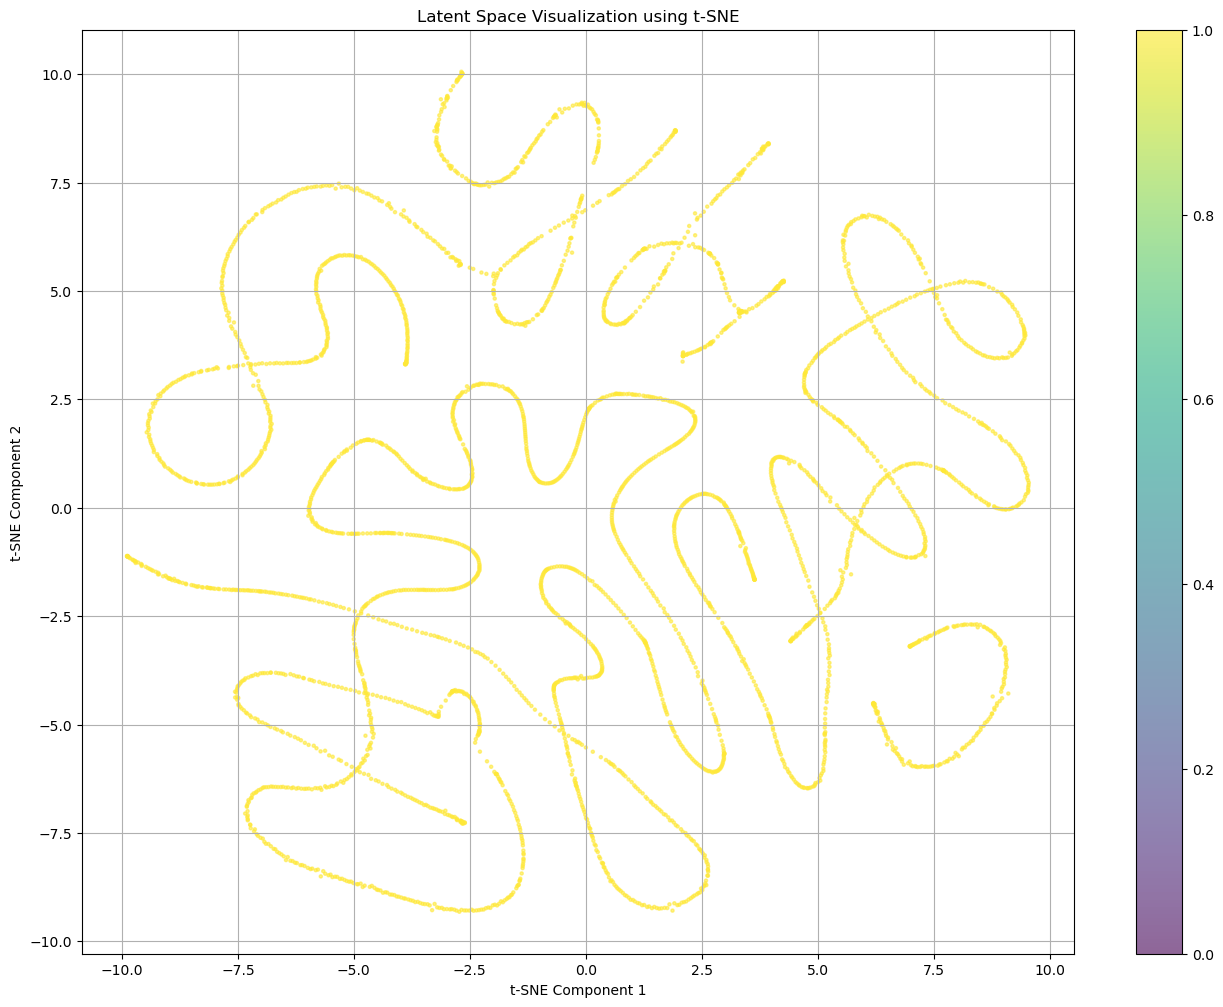

In [109]:
#Cell 13 Function to visualize the latent space with a color gradient
from sklearn.manifold import TSNE

def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])